In [1]:
import numpy as np
import pandas as pd
import matplotlib
import math
from sklearn import model_selection, ensemble, metrics, linear_model, preprocessing, pipeline
from matplotlib import pyplot as plt

In [70]:
data = pd.read_csv('dataset/undp_train.csv', na_values='nan')
test = pd.read_csv('dataset/undp_test.csv', na_values='nan')

In [71]:
index_columns = ['year',
                 'country',
                 'Human Development Index (HDI)',
                 'Gender Development Index (GDI)',
                 'Gender Inequality Index (GII)',
                 'HDI Rank',
                 'y'
                ]

In [72]:
# data = data[index_columns]
# test = test[index_columns[:-1]]

In [73]:
full = data.append(test, ignore_index=True)#.loc[:, ['year', 'country'] + index_columns + ['y']]

In [74]:
full

,year,country,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,...,Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII),HDI Rank,y
0,1990,Afghanistan,0.467,50.3,2193.0,0.466,2.6,1.5,0.298,0.122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,0.050220
1,1990,Albania,0.797,71.8,4415.0,0.572,11.6,7.8,0.644,0.584,...,NaN,NaN,NaN,NaN,2.3,0.1,NaN,NaN,63.0,0.082286
2,1990,Algeria,0.722,66.9,9989.0,0.695,9.6,3.6,0.578,0.385,...,NaN,NaN,NaN,NaN,9.0,0.1,NaN,NaN,89.0,0.064073
3,1990,Angola,0.389,45.3,4139.0,0.562,3.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,0.049559
4,1990,Argentina,0.794,71.6,10932.0,0.709,13.2,7.9,0.707,0.628,...,NaN,NaN,NaN,NaN,6.6,0.1,-0.4,NaN,43.0,0.074967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4750,2016,Yemen,0.709,66.1,1966.0,0.450,8.7,3.0,0.477,0.341,...,5.6,0.289,0.550,0.525,NaN,NaN,NaN,0.837,173.0,NaN
4751,2016,Vanuatu,0.770,70.0,2751.0,0.501,11.4,6.7,0.592,0.540,...,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN
4752,2016,Uruguay,0.885,77.5,19196.0,0.794,16.3,8.7,0.806,0.745,...,9.1,0.805,0.793,1.016,10.4,0.6,6.0,0.286,58.0,NaN
4753,2016,Viet Nam,0.849,75.2,5638.0,0.609,12.7,8.1,0.685,0.621,...,5.7,0.686,0.683,1.005,13.9,0.4,-5.8,0.323,119.0,NaN


In [75]:
# Data manipulation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS

def RMSE(x,y):
    return MSE(x,y)**0.5

numeric_data_indices = list(range(2,len(data.columns)-1))
# categorical_data_indices = [0, 1]
 
mean_enc_country_dict = data.groupby('country')['y'].mean().to_dict()
mean_enc_year_dict = data.groupby('year')['y'].mean().to_dict()

# Mean encode countries
def mean_enc_country(array):
    return np.array(([mean_enc_country_dict[country[0]] for country in array])).reshape(-1, 1)
# Mean encode years
def mean_enc_year(array):
    return np.array(([mean_enc_year_dict[year[0]] for year in array])).reshape(-1, 1)

# Pipeline
pipe = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [
        
            #categorical -- year
            ('year_categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, 0].reshape(-1, 1))),
#                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
                ('ordinal_encoding', preprocessing.OrdinalEncoder()),
#                ('mean_encoding', preprocessing.FunctionTransformer(mean_enc_year))
                ('scaling', preprocessing.StandardScaler())  
                        ])),
        
            #categorical -- country 
            ('country_categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, 1].reshape(-1, 1))),
#                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
                ('ordinal_encoding', preprocessing.OrdinalEncoder()),
#                ('mean_encoding', preprocessing.FunctionTransformer(mean_enc_country))
                ('scaling', preprocessing.StandardScaler()),
                        ])),
                
        
        
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('imputing', SimpleImputer(missing_values=np.nan, strategy='median')), #, fill_value=0)),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
        ]))
    ]
)

# shortcut for scorer
nrmse = 'neg_root_mean_squared_error'

X = full.iloc[:, :-1].values
y_train = data.iloc[:, -1].values

X = pipe.fit_transform(X)

X_train = X[:3865]
X_test = X[3865:]

In [76]:
X_train.shape

(3865, 77)

In [167]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(
    n_neighbors=1,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=1,
    metric='minkowski',
    metric_params=None,
    n_jobs=3,
)

knn.fit(X_train, y_train)

print(MSE(y_train, knn.predict(X_train))**0.5)

cvs = -CVS(knn, X_train, y_train, scoring=nrmse, cv=5)
print(cvs.mean(), 'CV score 5-fold of KNN on train')
cvs

0.0
0.013864540743081872 CV score 5-fold of KNN on train


array([0.01196401, 0.00541261, 0.00330623, 0.01202056, 0.03661929])

In [168]:
#XGBoost WITHOUT target transform
import xgboost as xgb
XGB = xgb.XGBRegressor(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=500,
    verbosity=1,
    silent=None,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=3,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.5,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=0.1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    missing=None,
    importance_type='gain')
XGB.fit(X_train, y_train)

print(MSE(y_train, XGB.predict(X_train))**0.5)
# print(MSE(y_test, XGB.predict(X_test))**0.5)

0.0013843550020657632


In [137]:
cvs = -CVS(XGB, X_train,y_train, scoring=nrmse, cv=5)
print(cvs.mean(), 'CV score 5-fold of XGB on train')
cvs

0.015013250599735234 CV score 5-fold of XGB on train


array([0.01297999, 0.0109612 , 0.00695155, 0.00858886, 0.03558465])

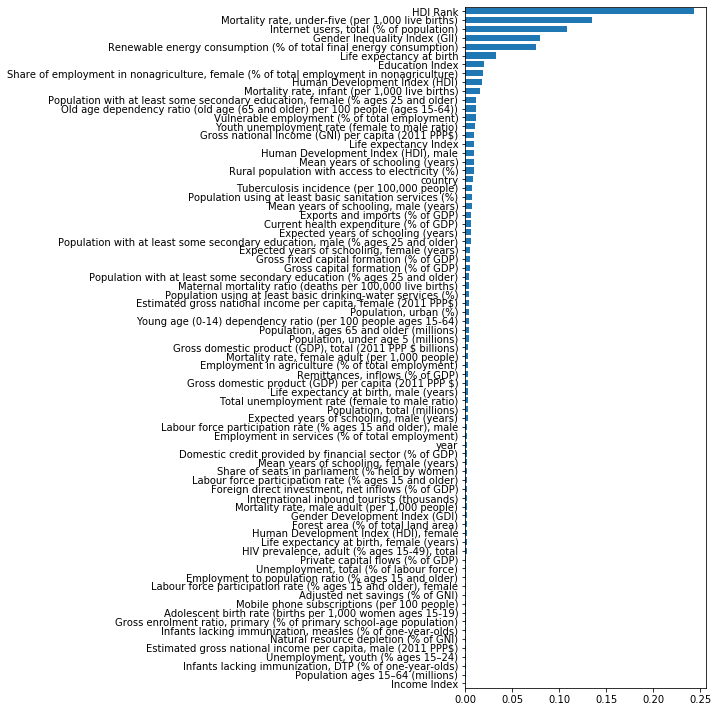

In [80]:
tree_importance_sorted_idx = np.argsort(XGB.feature_importances_)
tree_indices = np.arange(0, len(XGB.feature_importances_)) + 0.5

fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(tree_indices,
         XGB.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax.set_yticklabels(data.columns[tree_importance_sorted_idx])
ax.set_yticks(tree_indices)
ax.set_ylim((0, len(XGB.feature_importances_)))
fig.tight_layout()
plt.show()

In [169]:
model = ensemble.VotingRegressor([('knn', knn), ('XGB', XGB)])

In [170]:
cvs = -CVS(model, X_train, y_train, scoring=nrmse, cv=5)
print(cvs.mean(), 'CV score 5-fold of Ensemble on train')
cvs

0.012836541217007402 CV score 5-fold of Ensemble on train


array([0.01074367, 0.00642605, 0.00393546, 0.00804431, 0.03503321])

In [171]:
model.fit(X_train, y_train)
a = model.predict(X_test)
preds = a
for i in range(99):
    (X_train_rand, temp1,
     y_train_rand, temp2) = model_selection.train_test_split(X_train,
                                                        y_train,
                                                        test_size = 0.05,
                                                        shuffle=True,
                                                        random_state=i)
    model.fit(X_train_rand, y_train_rand)
    preds = np.vstack((preds, model.predict(X_test)))

In [172]:
preds

array([[0.04164563, 0.0393776 , 0.03900826, ..., 0.06707645, 0.05393765,
        0.023494  ],
       [0.041382  , 0.03865245, 0.03844309, ..., 0.06633866, 0.05484535,
        0.02325138],
       [0.04180743, 0.03895255, 0.03821765, ..., 0.0630011 , 0.05573847,
        0.02339267],
       ...,
       [0.04100336, 0.03859893, 0.0386491 , ..., 0.06392065, 0.0543881 ,
        0.02408339],
       [0.04177311, 0.0393595 , 0.03933139, ..., 0.06438175, 0.05345361,
        0.02440355],
       [0.04082745, 0.03880718, 0.03880718, ..., 0.07310767, 0.05050345,
        0.02672746]])

In [382]:
alphas = (-np.log(preds + 0.01) + 3) ** 2 / 1000

In [419]:
alloc = np.zeros(890)
n = 10000
for i in range(n):
    rnd = np.random.randint(0, 100, 890)
    # take a random sample from the alphas matrix, in a sense that for each row of alphas.T 
    # there is an equal chance to pick any of the 100 elements
    sample = np.array([row[rnd[i]] for i, row in enumerate(alphas.T)])
    # indices of a sorted array of 'sample'
    sample_argsort = np.argsort(sample)[::-1]
    # indices of the 50 largest by alpha countries with EEI < 0.7 (their index is less than 67)
    eei_ind = [x for x in sample_argsort if x < 66][:50]
    # 
    rest_ind = [x for x in sample_argsort if x not in eei_ind][:450]
    alloc[eei_ind + rest_ind] = alloc[eei_ind + rest_ind] + 100/n

In [471]:
# To make sure the sum constraint is satisfied
alloc_mod = alloc.copy()
alloc_mod[0] = alloc_mod[0] - 0.00001

In [481]:
alloc[alloc>100]

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 10

In [472]:
alloc[:66].sum()

6583.460000000932

In [473]:
alloc_mod[:66].sum()

6583.4599900009325

In [474]:
alloc.sum()

50000.000000006825

In [475]:
(alloc_mod).sum()

49999.99999000683

In [444]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [476]:
answer3 = pd.DataFrame({'pred': y_pred, 'opt_pred':alloc_mod})

In [477]:
answer3.index.name = 'index'

In [478]:
answer3.to_csv('answer3.csv')